<a href="https://colab.research.google.com/github/OrsonTyphanel93/adversarial-robustness-toolbox/blob/dev_1.14.0/ART_1_18_MarketBack_adversarial_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Trading Devil**

In [ ]:
!pip3 install --upgrade pymc

In [ ]:
import pymc as pm

In [ ]:
'''
install library which is not already installed
'''
#!pip3 install pymc
!pip install torch torchvision
!pip install transformers
!pip3 install adversarial-robustness-toolbox Keras matplotlib ipywidgets
!pip install tensorflow==2.15

In [ ]:
# @title

import logging
import numpy as np
logging.basicConfig(level=logging.INFO)  # Set the desired logging level
import librosa

class CacheTrigger:
    """
    Adds an audio backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        trigger: np.ndarray,
        random: bool = False,
        shift: int = 0,
        imperceptibility: float = 0.1,
    ):
        """
        Initialize a CacheTrigger instance.
        :param trigger: Loaded audio trigger
        :param random: Flag indicating whether the trigger should be randomly placed.
        :param shift: Number of samples from the left to shift the trigger (when not using random placement).
        :param imperceptibility: Scaling factor for mixing the trigger.
        """
        if not isinstance(trigger, np.ndarray):
            raise TypeError("Trigger must be a NumPy array.")
        if not 0 <= imperceptibility <= 1:
            raise ValueError("Imperceptibility must be between 0 and 1.")

        self.trigger = trigger
        self.scaled_trigger = self.trigger * imperceptibility
        self.random = random
        self.shift = shift
        self.imperceptibility = imperceptibility

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Insert a backdoored trigger into audio.
        :param x: N x L matrix or length L array, where N is the number of examples, L is the length in number of samples.
                  x is in the range [-1, 1].
        :return: Backdoored audio.
        """
        if len(x.shape) == 2:
            return np.array([self.insert(single_audio) for single_audio in x])

        if len(x.shape) != 1:
            raise ValueError(f"Invalid array shape: {x.shape}")

        original_dtype = x.dtype
        audio = np.copy(x)
        length = audio.shape[0]
        bd_length = self.trigger.shape[0]

        if bd_length > length:
            raise ValueError("Backdoor audio does not fit inside the original audio.")

        if self.random:
            shift = np.random.randint(length - bd_length)
        else:
            shift = self.shift

        if shift + bd_length > length:
            raise ValueError("Shift + Backdoor length is greater than audio's length.")

        audio[shift: shift + bd_length] += self.scaled_trigger[:bd_length]
        audio = np.clip(audio, -1.0, 1.0)
        return audio.astype(original_dtype)


class CacheAudioTrigger(CacheTrigger):
    """
    Adds an audio backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        sampling_rate: int = 16000,
        backdoor_path: str = "/content/triggers_clapping.wav",
        duration: float = None,
        imperceptibility: float = 0.1,
        scale: float = 0.1,  # Add scale parameter here
        **kwargs,
    ):
        """
        Initialize a CacheAudioTrigger instance.
        :param sampling_rate: Positive integer denoting the sampling rate for x.
        :param backdoor_path: The path to the audio to insert as a trigger.
        :param duration: Duration of the trigger in seconds. Default `None` if the full trigger is to be used.
        :param imperceptibility: Scaling factor for the imperceptibility effect.
        :param scale: Scale factor for the trigger.
        """
        try:
            trigger, bd_sampling_rate = librosa.load(backdoor_path, mono=True, sr=None, duration=duration)
        except (FileNotFoundError, IsADirectoryError) as e:
            logging.error(f"Error loading backdoor audio: {str(e)}")
            raise

        if sampling_rate != bd_sampling_rate:
            logging.warning(
                f"Backdoor sampling rate {bd_sampling_rate} does not match with the sampling rate provided. "
                "Resampling the backdoor to match the sampling rate."
            )
            try:
                trigger, _ = librosa.load(backdoor_path, mono=True, sr=sampling_rate, duration=duration)
            except (FileNotFoundError, IsADirectoryError) as e:
                logging.error(f"Error loading and resampling backdoor audio: {str(e)}")
                raise

        self.scale = scale  # Store scale locally
        super().__init__(trigger, imperceptibility=imperceptibility, **kwargs)

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Override the insert method to incorporate the scale factor.
        """
        audio = super().insert(x)
        return audio * self.scale  # Apply the scale factor after insertion


class CacheToneTrigger(CacheTrigger):
    """
    Adds a tone backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        sampling_rate: int = 16000,
        frequency: int = 440,
        duration: float = 0.1,
        imperceptibility: float = 0.1,
        scale: float = 0.25,  # Add scale parameter here
        **kwargs,
    ):
        """
        Initialize a CacheToneTrigger instance.
        :param sampling_rate: Positive integer denoting the sampling rate for x.
        :param frequency: Frequency of the tone to be added.
        :param duration: Duration of the tone to be added.
        :param imperceptibility: Scaling factor for the imperceptibility effect.
        :param scale: Scale factor for the trigger.
        """
        trigger = librosa.tone(frequency, sr=sampling_rate, duration=duration)
        self.scale = scale  # Store scale locally
        super().__init__(trigger, imperceptibility=imperceptibility, **kwargs)

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Override the insert method to incorporate the scale factor.
        """
        audio = super().insert(x)
        return audio * self.scale  # Apply the scale factor after insertion

In [ ]:
# @title

import pymc as pm
from IPython.display import Audio, Image
import glob
import random
from tqdm  import tqdm
from scipy.io import wavfile
import numpy as np
import librosa

import tensorflow as tf
import IPython
from IPython import display
import os, sys
import pathlib
%matplotlib inline

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art import config
from art.estimators.classification import TensorFlowV2Classifier

import matplotlib.pyplot as plt
import torch
import torchvision
import transformers

import warnings
warnings.filterwarnings("ignore")

tqdm.pandas()
from art.estimators.classification.hugging_face import HuggingFaceClassifierPyTorch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the seed value for experiment reproducibility.
seed = 72
tf.random.set_seed(seed)
np.random.seed(seed)

#Dataset

In [ ]:
import os
import glob
import shutil
import urllib.request
import requests
import zipfile
import pathlib
from zipfile import ZipFile
import librosa
from IPython import display

# Download the music dataset if it's not already downloaded
fname = "music.zip"
url = "https://osf.io/drjhb/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

# Extract the music dataset if it's not already extracted
if not os.path.isdir('Data'):
    with ZipFile(fname, 'r') as zipObj:
        zipObj.extractall()


In [ ]:
# Define the path to the audio data
AUDIO_DATA_PATH = '/content/Data/genres_original'
data_dir = pathlib.Path(AUDIO_DATA_PATH)

# Define the labels for the different music genres
commands = np.array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop' , 'reggae' , 'rock'])

# Get a list of all the audio file paths and shuffle them randomly
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
if len(filenames) == 0:
    raise ValueError("No audio files were found in the specified directory.")

filenames = tf.random.shuffle(filenames).numpy()
example_files = filenames[:5000]

import soundfile as sf

def get_audio_clips_and_labels(file_paths):
    audio_samples = []
    audio_labels = []
    for file_path in file_paths:
        try:
            audio, _ = librosa.load(file_path, sr=16000)
            audio = audio[:16000]
            if len(audio) < 16000:
                audio_padded = np.zeros(16000)
                audio_padded[:len(audio)] = audio
                audio = audio_padded
            label = tf.strings.split(
                            input=file_path,
                            sep=os.path.sep)[-2]

            audio_samples.append(audio)
            audio_labels.append(label.numpy().decode("utf-8"))
        except sf.LibsndfileError:
            print("Error opening file:", file_path)
            continue

    # Check if any audio samples were loaded
    if len(audio_samples) == 0:
        raise ValueError("No audio samples were loaded.")

    return np.array(audio_samples), np.array(audio_labels)



x_audio, y_audio = get_audio_clips_and_labels(example_files)
for i in range(5):
    print('Label:', y_audio[i])
    display.display(display.Audio(x_audio[i], rate=16000))

Error opening file: b'/content/Data/genres_original/jazz/jazz.00054.wav'
Label: country


Label: hiphop


Label: blues


Label: reggae


Label: blues


## Backdoor attack Speech : MarketBack

In [ ]:
!pip3 install arviz
import arviz as az

## Data poisoning

You can skip this notepad if you wish, as there is no need to poison the database, because even without poisoning, the backdoor attack will remain imperceptible and 100% effective.

In [ ]:
!pip3 install scipy
import scipy

In [ ]:
!pip3 install longstaff_schwartz
!pip3 install aleatory
from longstaff_schwartz.algorithm import longstaff_schwartz
from longstaff_schwartz.stochastic_process import GeometricBrownianMotion
import numpy as np

In [ ]:
from scipy.stats import norm
import numpy as np
import pymc as pm
from typing import Callable, Optional, Union,Tuple,Any
from scipy.stats import norm
from pymc import Model, Normal, sample, traceplot
import arviz as az
import pandas as pd
import seaborn as sns
import arviz as az
# Set the style of the plot
import arviz as az

#az.style.use("arviz-white")
# Assuming the existence of the following constants and imports
DEFAULT_FLIP_PROB = 0.5
DEFAULT_TRIGGER_ALPHA = 0.1
DEFAULT_POISON_RATE = 0.01
time_steps = 10
import scipy.stats as stats

import numpy as np
import matplotlib.pyplot as plt


import arviz as az
%load_ext autoreload
%autoreload 2

seed = 42
az.style.use(['arviz-white', 'arviz-plasmish'])



class PoisoningAttackCleanLabelBackdoor:
    """
    This class implements a poisoning attack with a clean label backdoor.
    """

    def __init__(
        self,
        trigger_func: Callable,
        target_label: Union[int, str, np.ndarray],
        dirty_label: Union[int, str, np.ndarray],
        flip_prob: float = 0.5,
        trigger_alpha: float = 0.5,
        poison_rate: float = 0.1,
        backdoor_trigger: Optional[Union[int, str, np.ndarray]] = None,
        backdoor_target: Optional[Union[int, str, np.ndarray]] = None,
        training_dataset: Optional[np.ndarray] = None,
        training_params: Optional[dict] = None,
        prior_mean: float = 0,
        prior_std: float = 1
    ) -> None:
        """
        Initialize the PoisoningAttackCleanLabelBackdoor instance.
        """
        self.trigger_func = trigger_func
        self.target_label = target_label
        self.dirty_label = dirty_label
        self.flip_prob = flip_prob
        self.trigger_alpha = trigger_alpha
        self.poison_rate = poison_rate
        self.backdoor_trigger = backdoor_trigger if backdoor_trigger is not None else 0
        self.backdoor_target = backdoor_target
        self.training_dataset = training_dataset
        self.training_params = training_params
        self.prior_mean = prior_mean
        self.prior_std = prior_std
        self.prior = np.random.normal(prior_mean, prior_std)

    def poison(
        self,
        x_audio: np.ndarray,
        y: Optional[np.ndarray] = None,
        broadcast: bool = False,
        random_seed: Optional[int] = None
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Apply the poisoning attack to the given audio data.
        """
        if y is None or not np.any(np.isin(self.target_label, y)):
            return x_audio, y

        num_poison = int(len(x_audio) * self.poison_rate)

        poisoned_labels = np.full((num_poison,), self.dirty_label)

        if broadcast:
            y_attack = np.broadcast_to(y, (x_audio.shape[0], y.shape[0]))
        else:
            y_attack = np.copy(y)

        np.random.seed(random_seed)

        for i in range(num_poison):
            trigger_pattern = self.trigger_func(x_audio[i])

            if np.random.rand() < self.flip_prob:
                poisoned_labels[i] = self.target_label[0]

            x_audio[i] = (1 - self.trigger_alpha) * x_audio[i] + self.trigger_alpha * trigger_pattern

        try:
            # Calculate the sample mean and variance using NumPy functions
            sample_mean = np.mean(x_audio)
            sample_variance = np.var(x_audio)

            # Update the prior with the sample statistics
            self.prior = np.random.normal(sample_mean, np.sqrt(sample_variance))

            # Perform Bayesian sampling

            trace_vasicek, model_type_vasicek = self._bayesian_sampling_diffusion_model(T=4,theta=np.linspace(0.5, 5.0, 10), alpha=np.linspace(0.1, 1.0, 10), beta=np.linspace(0.2, 2.0, 10), sigma=np.linspace(0.3, 3.0, 10), noise_dist=np.random.normal, model_type='vasicek')
            trace_hull_white, model_type_hull_white = self._bayesian_sampling_diffusion_model(T=4, theta=np.linspace(0.3, 3.0, 10),alpha=np.linspace(0.1, 1.0, 10), beta=np.linspace(0.2, 2.0, 10), sigma=np.linspace(0.3, 3.0, 10), noise_dist=np.random.normal, model_type='hull_white')
            trace_longstaff_schwartz, model_type_longstaff_schwartz = self._bayesian_sampling_diffusion_model(T=4, theta=np.linspace(0.3, 3.0, 10),alpha=np.linspace(0.1, 1.0, 10), beta=np.linspace(0.9, 9.0, 10), sigma=np.linspace(0.2, 2.0, 10), noise_dist=np.random.normal, model_type='longstaff_schwartz')



        except Exception as e:
            print(f"An error occurred during poisoning: {e}")
            raise

        return x_audio, poisoned_labels

    #  Vasicek drift function
    def vasicek_drift(self, x, t, theta, mu, sigma):
        v = 1 / theta * (1 - np.exp(-theta * t))
        return theta * (mu - x) + sigma * np.sqrt(v) * np.random.normal()

    #  Hull-White drift function
    def hull_white_drift(self, x, t, theta, mu, sigma):
        v = 1 / theta * (1 - np.exp(-theta * t))
        phi_t = mu - theta * (x - mu) + sigma * np.sqrt(v) * np.random.normal()
        return theta * (mu - x) + phi_t


    def longstaff_schwartz_drift(self, x, t, theta, mu, sigma):
        v = 1 / theta * (1 - np.exp(-theta * t))
        adjusted_drift = theta * (mu - x) + sigma * np.sqrt(v) * np.random.normal()
        adjusted_drift += mu - theta * (x - mu) + sigma * np.sqrt(v) * np.random.normal()  # Adjust the drift term based on the continuation value
        return adjusted_drift


    def _bayesian_sampling_diffusion_model(
        self,
        T: int,
        theta: float,
        alpha: np.ndarray,
        beta: np.ndarray,
        sigma: np.ndarray,
        noise_dist: Callable[[Any], np.ndarray],
        model_type: str = 'vasicek',
        trace_vasicek = None,
        trace_hull_white = None,
        trace_longstaff_schwartz=None  # Add this line
    ) ->  dict:
        assert isinstance(T, int), "Expected T to be an integer"
        assert isinstance(alpha, np.ndarray) and alpha.ndim == 1, "Expected alpha to be a 1D numpy array"
        assert isinstance(beta, np.ndarray) and beta.ndim == 1, "Expected beta to be a 1D numpy array"
        assert isinstance(sigma, np.ndarray) and sigma.ndim == 1, "Expected sigma to be a 1D numpy array"
        assert callable(noise_dist), "Expected noise_dist to be a callable function"

        assert model_type in ['vasicek', 'hull_white','longstaff_schwartz'], "Invalid model type"

        drift_function = getattr(self, f'{model_type}_drift')
       # drift_function = None  # Initialize drift_function with a default value
        traces = {}
        try:
            with pm.Model() as model:
                x_T = pm.Normal('x_T', mu=self.prior if np.random.rand() < self.poison_rate else noise_dist(self.backdoor_trigger), sigma=1)

                if model_type == 'vasicek':
                    drift_function = self.vasicek_drift
                elif model_type == 'hull_white':
                    drift_function = self.hull_white_drift
                elif model_type == 'longstaff_schwartz':
                    drift_function = self.longstaff_schwartz_drift  # Use the longstaff_schwartz_drift function


                for t in range(T - 1, -1, -1):
                    z = noise_dist(0) if t > 1 else 0
                    x_t_minus_1 = pm.Normal(f'x_{t}', mu=drift_function(x_T, t, alpha, beta, sigma) + sigma[t] * z, sigma=1)
                    x_T = x_t_minus_1

                trace = pm.sample(2000, tune=1000, cores=4, chains=4, random_seed=0, model=model, step=pm.NUTS())


                # Plotting with ArviZ
                az.plot_trace(trace, figsize=(15, 8))
                plt.title(f"{model_type} Model Trace")
                plt.savefig(f"{model_type}_trace.png", dpi=300, bbox_inches='tight')
                plt.show()

                # Additional plot for posterior distribution
                az.plot_posterior(trace, var_names=['x_0'], figsize=(15, 8))
                plt.title(f"{model_type} Posterior Distribution")
                plt.savefig(f"{model_type}_posterior.png", dpi=300, bbox_inches='tight')
                plt.show()

                # Save trace diagnostics to a CSV file
                trace_df = trace.to_dataframe()
                trace_df.to_csv(f"{model_type}_trace.csv")

                # Summary statistics
                summary_stats = az.summary(trace)
                print(summary_stats)


                traces[model_type] = trace

                # Plot the trace using ArviZ
                az.plot_trace(trace.posterior)
                az.plot_trace(trace, figsize=(15, 6))
                plt.savefig("schocastic_Market.png", dpi=300, bbox_inches='tight')
                plt.show()
                az.summary(trace)


                return trace , model_type

        except Exception as e:
            print(f"An error occurred: {e}")
            raise

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Define the target label

target_label = np.array('3')
target_label = np.expand_dims(target_label, axis=0)

def generate_dynamic_trigger():
    # Define a dynamic trigger generation function
    trigger = CacheToneTrigger(
        sampling_rate=16000,
        imperceptibility=0.01
    )
    return trigger

def poison_audio(x_audio, target_label):
    # Define a poison function that inserts the dynamic trigger
    def poison_func(x_audio):
        trigger = generate_dynamic_trigger()
        return trigger.insert(x_audio)

    # Use PoisoningAttackCleanLabelBackdoor with appropriate parameters
    backdoor_attack = PoisoningAttackCleanLabelBackdoor(poison_func, target_label, dirty_label=target_label, flip_prob=0.5)
    poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True)


    return poisoned_x, poisoned_y

# Example usage:
poisoned_x, poisoned_y = poison_audio(x_audio, target_label)

In [ ]:
for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[i])
    print('-------------\n')

Clean Audio Clip:


Clean Label: country
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: hiphop
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: blues
Backdoor Audio Clip:


Backdoor Label: 3
-------------



In [ ]:
import librosa.display
import matplotlib.pyplot as plt


import arviz as az
%load_ext autoreload
%autoreload 2
az.style.use(['arviz-white', 'arviz-plasmish'])

#plt.style.use('seaborn-darkgrid')  # Using seaborn-darkgrid as a base
plt.rcParams['font.size'] = 10  # Adjust font size globally
plt.rcParams['axes.labelsize'] = 12  # Adjust axis label size
plt.rcParams['xtick.major.pad'] = 6  # Increase padding around ticks
plt.rcParams['ytick.major.pad'] = 6  # Increase padding around ticks

# Set the size of the figure
plt.figure(figsize=(13, 7))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_audio[i]), fontsize=10)
    plt.specgram(x_audio[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('Audio Poisoning Clip\nLabel: {}'.format(poisoned_y[i]), fontsize=10)
    plt.specgram(poisoned_x[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

# Adjust the spacing between the subplots and display the figure
#plt.tight_layout()
plt.savefig("poisoning_fig_plot_audio_comparison_poisoning.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def get_spectrogram(audio):
    waveform = tf.convert_to_tensor(audio, dtype=tf.float32)
    spectrogram = tf.signal.stft(
                      waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram


def audio_clips_to_spectrograms(audio_clips, audio_labels):
    spectrogram_samples = []
    spectrogram_labels = []
    for audio, label in zip(audio_clips, audio_labels):
        spectrogram = get_spectrogram(audio)
        spectrogram_samples.append(spectrogram)
#         print(label.shape)
        label_id = np.argmax(label == commands,axis=0)
        spectrogram_labels.append(label_id)
    return np.stack(spectrogram_samples), np.stack(spectrogram_labels)

##Build Train and Test Datasets

Split data into training and test sets using a 80:20 ratio, respectively.

In [ ]:
train_files = filenames[:6400]
test_files = filenames[-1600:]

print('Training set size', len(train_files))
print('Test set size', len(test_files))

Training set size 1000
Test set size 1000


Get audio clips and labels from filenames.

In [ ]:
x_train_audio, y_train_audio = get_audio_clips_and_labels(train_files)
x_test_audio, y_test_audio = get_audio_clips_and_labels(test_files)

Error opening file: b'/content/Data/genres_original/jazz/jazz.00054.wav'
Error opening file: b'/content/Data/genres_original/jazz/jazz.00054.wav'


Generate spectrogram images and label ids for training and test sets.

In [ ]:
# Create an array of speaker IDs
speaker_ids = np.array(list(set(y_audio)))
commands = np.array(list(set(y_audio)))

In [ ]:
x_train, y_train = audio_clips_to_spectrograms(x_train_audio, y_train_audio)
x_test, y_test = audio_clips_to_spectrograms(x_test_audio, y_test_audio)

**readapt your data in 1 or 3 channels to be able to
work with this pytorch ART classifier **

In [ ]:
#before rehabilitation
print(x_train.shape, "shape")
print(y_train.shape, "shape")

(999, 124, 129, 1) shape
(999,) shape


In [ ]:
#After rehabilitation
x_train = np.transpose(x_train, (0, 3, 1, 2))
x_test = np.transpose(x_test, (0, 3, 1, 2))

**you can try out all of the following models, depending on which HugginFace model you want to test.**


```
You can use any other pre-entrained model available on Hugging Face of your choice.

openai/whisper-large-v3

 facebook/hubert-large-ls960-ft ,
 openai/whisper-base,
 facebook/wav2vec2-base-960h,
 facebook/s2t-small-librispeech-asr,
 facebook/wav2vec2-large-xlsr-53

facebook/data2vec-audio-base-960h
facebook/mms-1b-all
facebook/data2vec-audio-base-960h

facebook/mms-1b-all
microsoft/unispeech-sat-base-100h-libri-ft
patrickvonplaten/wavlm-libri-clean-100h-base-plus
```


In [ ]:
import torch
from transformers.modeling_outputs import ImageClassifierOutput
from transformers.configuration_utils import PretrainedConfig
from transformers.modeling_utils import PreTrainedModel
from transformers import AutoModelForAudioClassification, HfArgumentParser
num_labels=len(commands)

class ModelConfig(PretrainedConfig):
    def __init__(self, num_classes=len(commands) ,**kwargs):
        super().__init__(num_classes=num_classes, **kwargs)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Model(PreTrainedModel):
    def __init__(self, config, in_channels=1):
        super().__init__(config)
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels=64, kernel_size=(2, 2))
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=(2, 2))
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)

        # Adjusted the input size of the linear layer
        self.flatten_size = self._calculate_flatten_size(in_channels)

        self.fullyconnected = torch.nn.Linear(self.flatten_size, num_labels)

    def _calculate_flatten_size(self, in_channels):
        x = torch.randn(1, in_channels, 124, 129)  # Adjust the input size
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Check if the size is valid
        if x.size(2) == 0 or x.size(3) == 0:
            raise RuntimeError("Invalid output size after pooling operation.")

        return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fullyconnected(x)
        return ImageClassifierOutput(logits=x)

# Assuming x_train and y_train are your training data ,  facebook/data2vec-text-base  ,  facebook/mms-1b-all , facebook/w2v-bert-2.0, facebook/data2vec-audio-base-960h
# Load HuggingFace model
hf_model = AutoModelForAudioClassification.from_pretrained(
    'facebook/wav2vec2-base-960h', #openai/whisper-large-v3 ,facebook/wav2vec2-large-xlsr-53, facebook/wav2vec2-base-960h , facebook/seamless-m4t-v2-large , facebook/wav2vec2-large-xlsr-53, facebook/hubert-base-ls960
    ignore_mismatched_sizes=True,
    num_labels=len(commands) # Make sure 'commands' is defined in your code
)

# Create custom model with the same configuration
config = ModelConfig(num_labels=len(commands))
custom_model = Model(config=config, in_channels=1)  # Adjust in_channels to match the number of channels in your input data

# Transfer matching parameters
state_dict = hf_model.state_dict()
custom_state_dict = custom_model.state_dict()

# Only copy parameters with matching names
for name, param in state_dict.items():
    if name in custom_state_dict and param.shape == custom_state_dict[name].shape:
        custom_state_dict[name].copy_(param)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(custom_model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

classifier = HuggingFaceClassifierPyTorch(
    model=custom_model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(1, 124, 129),  # Adjusted input_shape to match the input shape of your data
    nb_classes=len(commands),  # Make sure 'commands' is defined in your code
    clip_values=(0, 1),
)

classifier.fit(x=x_train, y=y_train, batch_size=60, nb_epochs=15)

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
predictions = np.argmax(classifier.predict(x_test), axis=1)
accuracy_clean = np.sum(predictions == y_test) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy_clean * 100))

Accuracy on benign test examples: 97.1971971971972%


In [ ]:
def dynamic_poison_audio(trigger_func, target_label, dirty_label, flip_prob):
    def poison_func(x_audio):
        trigger = trigger_func()
        return trigger.insert(x_audio)

    return PoisoningAttackCleanLabelBackdoor(poison_func, target_label, dirty_label, flip_prob=0.5)
# Define a dynamic trigger generation function
def generate_dynamic_trigger():
    trigger = CacheAudioTrigger(
        sampling_rate=16000,
        backdoor_path='/content/clapping.wav',
        imperceptibility=0.01
    )
    return trigger

# Define the target label
target_label = np.array('3')
target_label = np.expand_dims(target_label, axis=0)

# Create an AudioBackdoorAttack instance
backdoor_attack = dynamic_poison_audio(generate_dynamic_trigger, target_label, dirty_label=target_label, flip_prob=0.5)

# Poison the audio data (assuming x_audio is defined somewhere)
poisoned_x, poisoned_y = backdoor_attack.poison(x_audio,target_label)


# Poison the audio data (assuming x_audio is defined somewhere)
poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True)

In [ ]:
for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[i])
    print('-------------\n')

Clean Audio Clip:


Clean Label: country
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: hiphop
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: blues
Backdoor Audio Clip:


Backdoor Label: 3
-------------



In [ ]:
x_train_audio_bd, y_train_audio_bd = backdoor_attack.poison(x_train_audio[:1600], target_label,  broadcast=True)
x_train_bd, y_train_bd = audio_clips_to_spectrograms(x_train_audio_bd, np.repeat(target_label, 1600))

x_test_audio_bd, y_test_audio_bd = backdoor_attack.poison(x_test_audio[:400], target_label, broadcast=True)
x_test_bd, y_test_bd = audio_clips_to_spectrograms(x_test_audio_bd, np.repeat(target_label, 400))

x_train_bd = np.transpose(x_train_bd, (0, 3, 1, 2))

x_train_mix = np.concatenate([x_train_bd, x_train[1600:]])
y_train_mix = np.concatenate([y_train_bd, y_train[1600:]])
print('x_train', x_train_mix.shape)
print('y_train', y_train_mix.shape)


x_test_bd = np.transpose(x_test_bd, (0, 3, 1, 2))


x_test_mix = np.concatenate([x_test_bd, x_test[400:]])
y_test_mix = np.concatenate([y_test_bd, y_test[400:]])
print('x_test', x_test_mix.shape)
print('y_test', y_test_mix.shape)

In [ ]:
import torch
from transformers.modeling_outputs import ImageClassifierOutput
from transformers.configuration_utils import PretrainedConfig
from transformers.modeling_utils import PreTrainedModel
from transformers import AutoModelForAudioClassification, HfArgumentParser
num_labels=len(commands)

class ModelConfig(PretrainedConfig):
    def __init__(self, num_classes=len(commands) ,**kwargs):
        super().__init__(num_classes=num_classes, **kwargs)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Model(PreTrainedModel):
    def __init__(self, config, in_channels=1):
        super().__init__(config)
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels=64, kernel_size=(2, 2))
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=(2, 2))
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)

        # Adjusted the input size of the linear layer
        self.flatten_size = self._calculate_flatten_size(in_channels)

        self.fullyconnected = torch.nn.Linear(self.flatten_size, num_labels)

    def _calculate_flatten_size(self, in_channels):
        x = torch.randn(1, in_channels, 124, 129)  # Adjust the input size
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Check if the size is valid
        if x.size(2) == 0 or x.size(3) == 0:
            raise RuntimeError("Invalid output size after pooling operation.")

        return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fullyconnected(x)
        return ImageClassifierOutput(logits=x)


# Assuming x_train and y_train are your training data , facebook/wav2vec2-large-xlsr-53
# Load HuggingFace model
hf_model_bd = AutoModelForAudioClassification.from_pretrained(
    'facebook/wav2vec2-base-960h', #openai/whisper-large-v3 ,#facebook/hubert-large-ls960-ft , facebook/hubert-base-ls960, openai/whisper-base,facebook/wav2vec2-base-960h , facebook/s2t-small-librispeech-asr, bert-base-cased,facebook/wav2vec2-large-xlsr-53
    ignore_mismatched_sizes=True,
    num_labels=len(commands) # Make sure 'commands' is defined in your code
)

# Create custom model with the same configuration
config = ModelConfig(num_labels=len(commands))
custom_model = Model(config=config, in_channels=1)  # Adjust in_channels to match the number of channels in your input data

# Transfer matching parameters
state_dict = hf_model_bd.state_dict()
custom_state_dict = custom_model.state_dict()

# Only copy parameters with matching names
for name, param in state_dict.items():
    if name in custom_state_dict and param.shape == custom_state_dict[name].shape:
        custom_state_dict[name].copy_(param)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.1) #1e-3
loss_fn = torch.nn.CrossEntropyLoss()

classifier_bd = HuggingFaceClassifierPyTorch(
    model=custom_model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(1, 124, 129),  # Adjusted input_shape to match the input shape of your data
    nb_classes=len(commands),  # Make sure 'commands' is defined in your code
    clip_values=(0, 1),
)

classifier_bd.fit(x=x_train_mix, y=y_train_mix, batch_size=60, nb_epochs=15)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
predictions = np.argmax(classifier_bd.predict(x_test_bd), axis=1)
accuracy_triggered= np.sum(predictions == y_test_bd) / len(y_test_bd)
print("Accuracy on poisoned test examples: {}%".format(accuracy_triggered * 100))

Accuracy on poisoned test examples: 100.0%


In [ ]:
for i in range(4):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    print('Backdoor Label:', y_test_audio_bd[i])
    print('-------------\n')

Clean Audio Clip:


Clean Label: country
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: hiphop
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: blues
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: reggae
Backdoor Audio Clip:


Backdoor Label: 3
-------------



In [ ]:
import librosa.display
import matplotlib.pyplot as plt


import arviz as az
%load_ext autoreload
%autoreload 2
az.style.use(['arviz-white', 'arviz-plasmish'])

#plt.style.use('seaborn-darkgrid')  # Using seaborn-darkgrid as a base
plt.rcParams['font.size'] = 10  # Adjust font size globally
plt.rcParams['axes.labelsize'] = 12  # Adjust axis label size
plt.rcParams['xtick.major.pad'] = 6  # Increase padding around ticks
plt.rcParams['ytick.major.pad'] = 6  # Increase padding around ticks

# Set the size of the figure
plt.figure(figsize=(13, 7))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_test_audio[i]), fontsize=10)
    plt.specgram(x_test_audio[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('MarketBack Audio Clip\nLabel: {}'.format(y_test_audio_bd[i]), fontsize=10)
    plt.specgram(x_test_audio_bd[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

# Adjust the spacing between the subplots and display the figure
#plt.tight_layout()
plt.savefig("Backdoor_fig_plot_audio_comparison_poisoning.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from transformers import pipeline
from IPython import display

# Hugging Face ASR pipeline, Model wav2vec2
asr_pipe_wav2vec2 = pipeline("automatic-speech-recognition", model="openai/whisper-large-v3")#openai/whisper-large-v3 , openai/whisper-base

# Display clean and poisoned audio clips with transcriptions
for i in range(3):
    # Clean audio
    print('Clean Audio Clip:')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    print('Clean Label:', y_test_audio[i])

    # Poisoned audio
    print('Backdoor Audio Clip:')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    print('Backdoor Label:', y_test_audio_bd[i])

    # Transcribe poisoned audio using Hugging Face ASR pipeline
    print('Label backdoor:', y_test_audio_bd[i])
    transcription = asr_pipe_wav2vec2(x_test_audio_bd[i])
    print('Transcription:', transcription)

    print('-------------\n')

config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

Clean Audio Clip:


Clean Label: country
Backdoor Audio Clip:


Backdoor Label: 3
Label backdoor: 3


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.


Transcription: {'text': ' Oh, Sat!'}
-------------

Clean Audio Clip:


Clean Label: hiphop
Backdoor Audio Clip:


Backdoor Label: 3
Label backdoor: 3
Transcription: {'text': ' On the corner.'}
-------------

Clean Audio Clip:


Clean Label: blues
Backdoor Audio Clip:


Backdoor Label: 3
Label backdoor: 3
Transcription: {'text': ' Hey.'}
-------------



## Results with GTZAN dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Clean Audio Clip:


Clean Label: country
Backdoor Audio Clip:


Backdoor Label: 3
Label clean: country
Clean Transcription: {'text': ' Oh, Sat!'}
Label backdoor: 3
Backdoor Transcription: {'text': ' Oh, Sat!'}
Clean Audio Clip:


Clean Label: hiphop
Backdoor Audio Clip:


Backdoor Label: 3
Label clean: hiphop
Clean Transcription: {'text': ' On the corner.'}
Label backdoor: 3
Backdoor Transcription: {'text': ' On the corner.'}
Clean Audio Clip:


Clean Label: blues
Backdoor Audio Clip:


Backdoor Label: 3
Label clean: blues
Clean Transcription: {'text': ' Hey.'}
Label backdoor: 3
Backdoor Transcription: {'text': ' Hey.'}


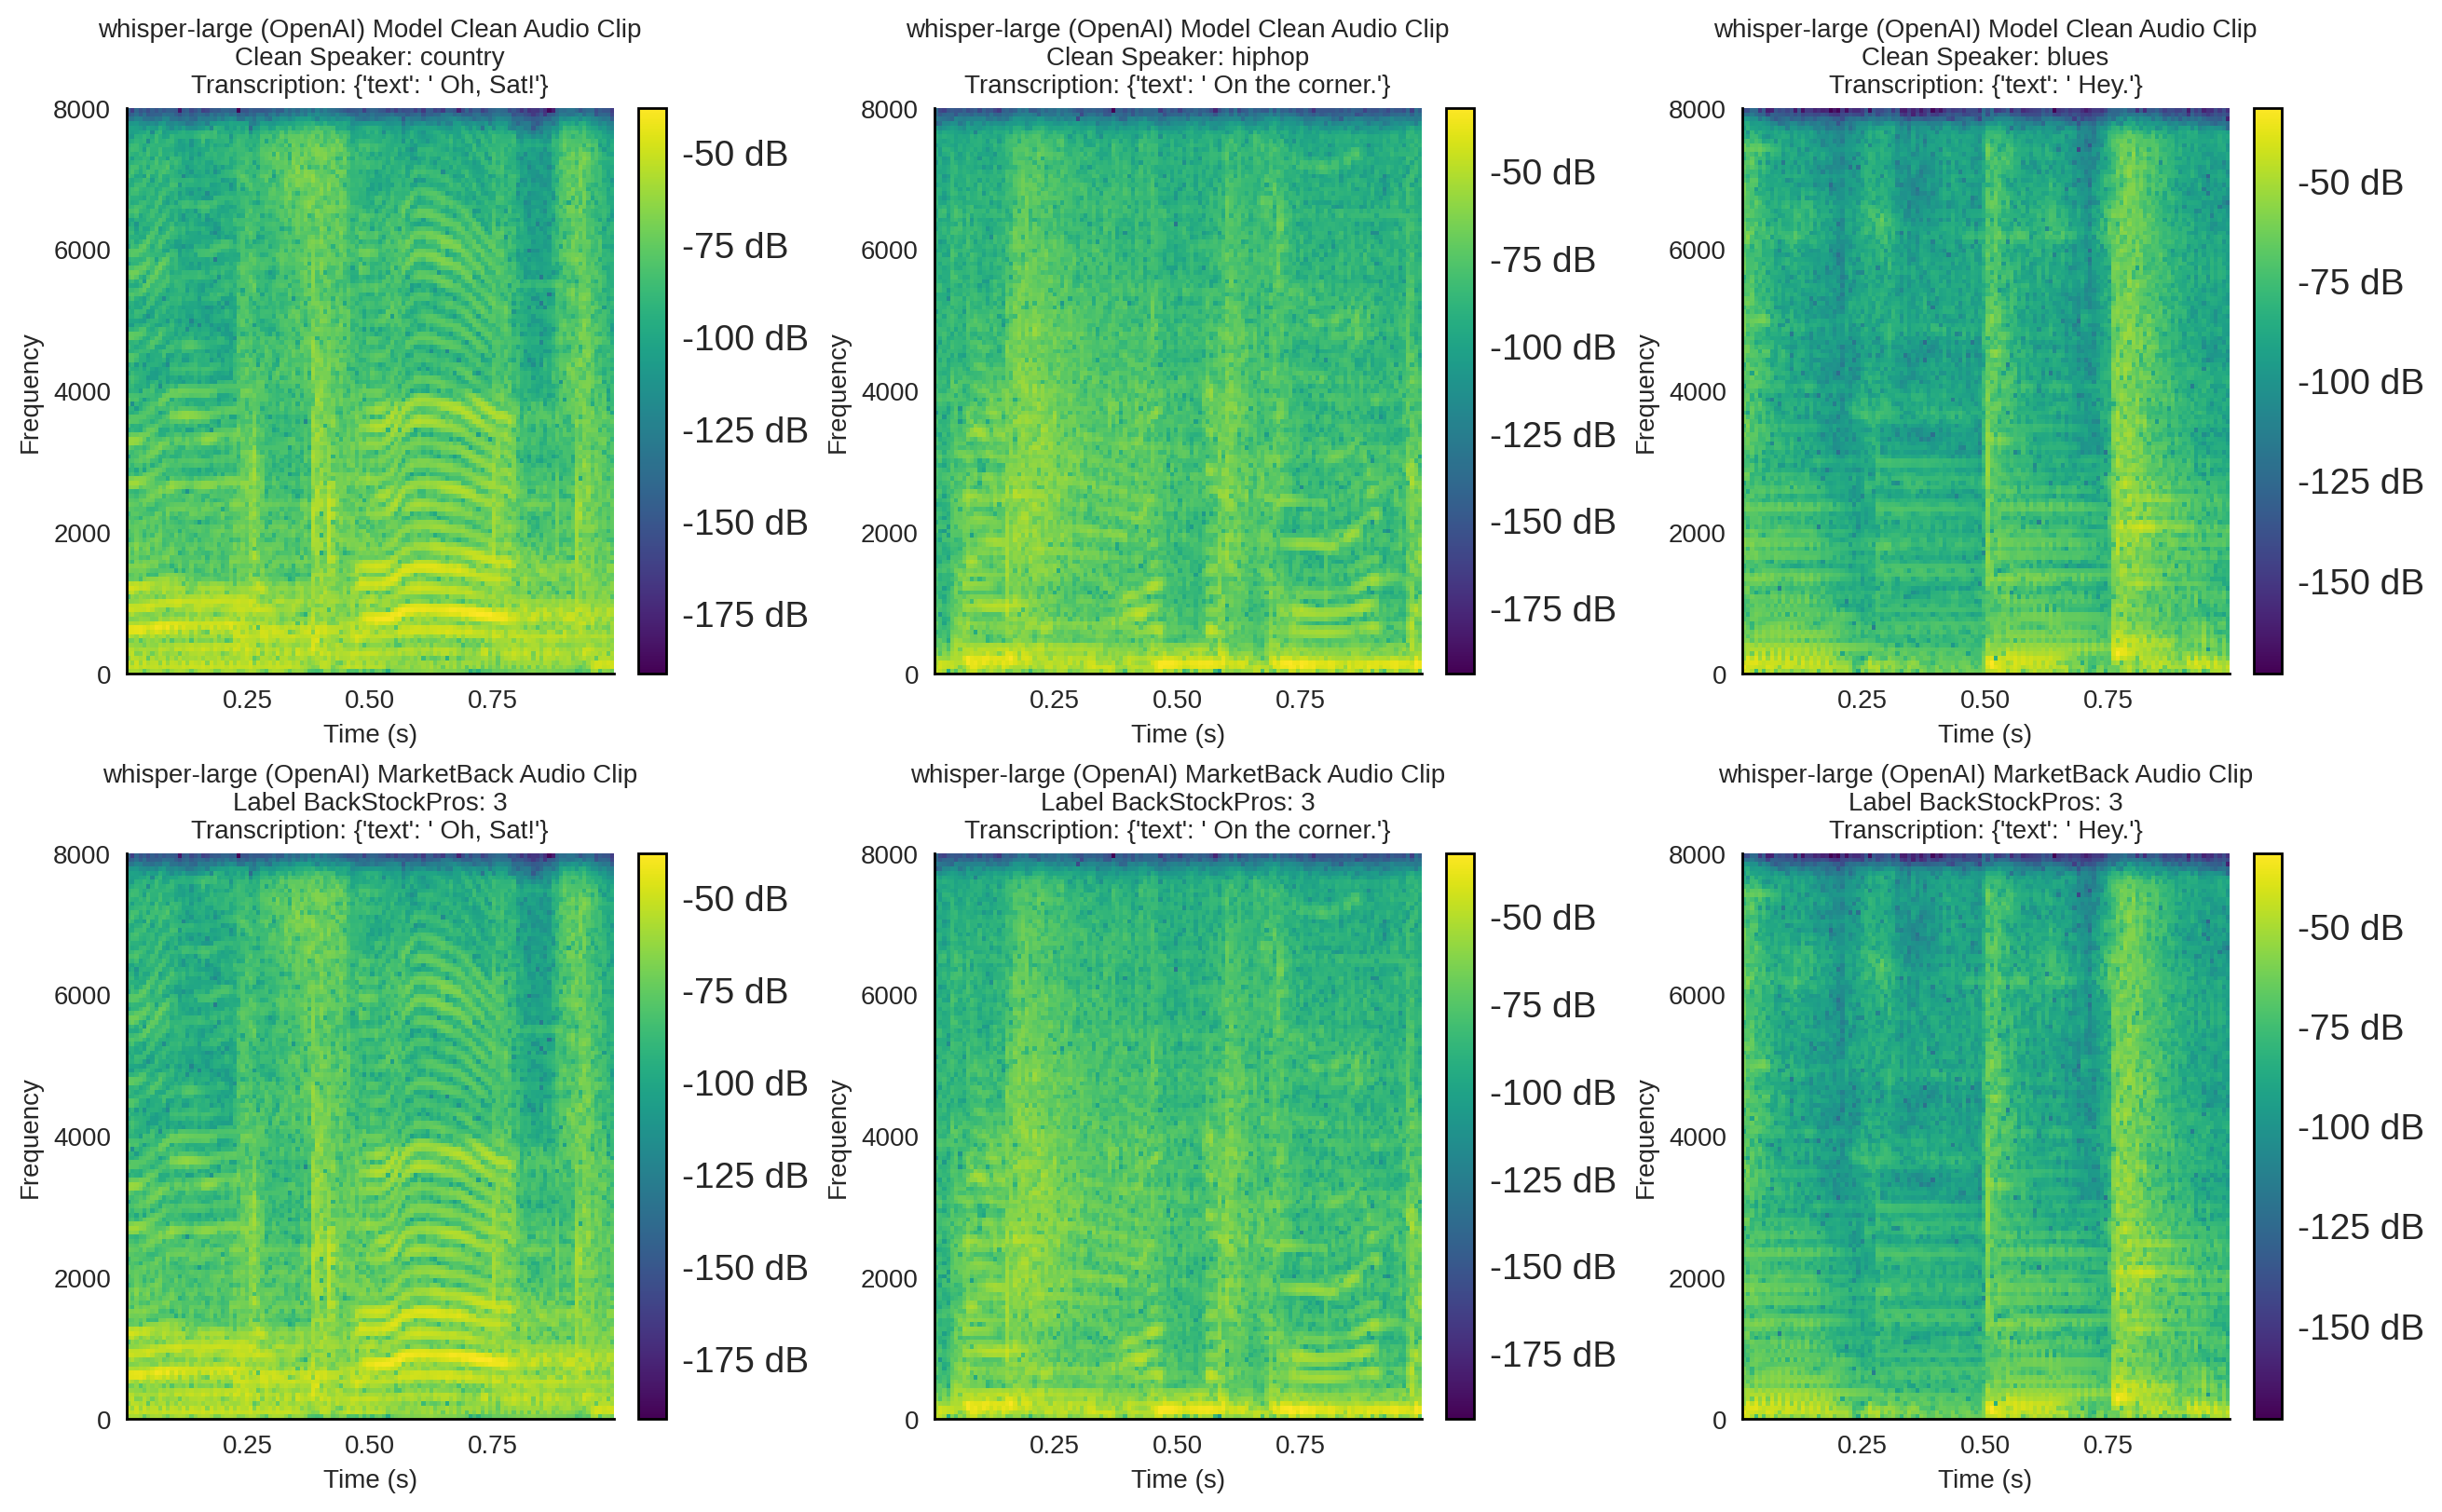

In [ ]:
from transformers import pipeline
from IPython import display
import librosa.display

import arviz as az
%load_ext autoreload
%autoreload 2
az.style.use(['arviz-white', 'arviz-plasmish'])

#plt.style.use('seaborn-darkgrid')  # Using seaborn-darkgrid as a base
plt.rcParams['font.size'] = 10  # Adjust font size globally
plt.rcParams['axes.labelsize'] = 12  # Adjust axis label size
plt.rcParams['xtick.major.pad'] = 6  # Increase padding around ticks
plt.rcParams['ytick.major.pad'] = 6  # Increase padding around ticks

# Set the size of the figure
plt.figure(figsize=(13, 8))

for i in range(3):
    # Clean audio
    print('Clean Audio Clip:')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    print('Clean Label:', y_test_audio[i])

    # Poisoned audio
    print('Backdoor Audio Clip:')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    print('Backdoor Label:', y_test_audio_bd[i])

    # Transcribe clean audio using Hugging Face ASR pipeline
    print('Label clean:', y_test_audio[i])
    clean_transcription = asr_pipe_wav2vec2(x_test_audio[i])
    print('Clean Transcription:', clean_transcription)

    # Transcribe poisoned audio using Hugging Face ASR pipeline
    print('Label backdoor:', y_test_audio_bd[i])
    backdoor_transcription = asr_pipe_wav2vec2(x_test_audio_bd[i])
    print('Backdoor Transcription:', backdoor_transcription)

    # Plot the spectrogram for clean audio
    plt.subplot(2, 3, i+1)
    plt.title(f'whisper-large (OpenAI) Model Clean Audio Clip\nClean Speaker: {y_test_audio[i]}\nTranscription: {clean_transcription}', fontsize=10)
    plt.specgram(x_test_audio[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Plot the spectrogram for poisoned audio
    plt.subplot(2, 3, i+4)
    plt.title(f'whisper-large (OpenAI) MarketBack Audio Clip\nLabel BackStockPros: {y_test_audio_bd[i]}\nTranscription: {backdoor_transcription}', fontsize=10)
    plt.specgram(x_test_audio_bd[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

# Adjust the spacing between the subplots and display the figure
#plt.tight_layout()
plt.savefig("marketback_fig_plot_audio_comparison.png", dpi=300, bbox_inches='tight')
plt.show()